In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import feature, filters
import warnings
warnings.filterwarnings('ignore')

class SpeckDetectingDecoder:
    def __init__(self, filename):
        self.filename = filename
        with open(filename, 'rb') as f:
            self.data = f.read()
        
        self.image_data = self.data[7:]
        self.data_size = len(self.image_data)
        print(f"Data size: {self.data_size} bytes")
    
    def try_configuration(self, dim, dtype, byte_order='=', num_images=1, offset=0):
        """Try reading images with given parameters"""
        try:
            bytes_per_pixel = np.dtype(dtype).itemsize
            bytes_per_image = dim * dim * bytes_per_pixel
            total_bytes_needed = bytes_per_image * num_images
            
            if offset + total_bytes_needed > self.data_size:
                return None
            
            full_dtype = f"{byte_order}{dtype.__name__}"
            array = np.frombuffer(self.image_data[offset:offset+total_bytes_needed], dtype=full_dtype)
            images = array.reshape((num_images, dim, dim))
            return images
        except:
            return None
    
    def detect_specks_and_features(self, img):
        """Look for small features/specks that could be real AFM data"""
        if img is None:
            return 0, 0, "No image"
        
        # Remove overall trends to enhance small features
        img_flat = img - ndimage.gaussian_filter(img, sigma=5)
        
        # Find local maxima (potential specks/features)
        from skimage.morphology import local_maxima
        maxima = local_maxima(img_flat)
        
        # Count significant features (not just noise)
        speck_count = np.sum(maxima)
        
        # Alternative: use edge detection to find features
        edges = feature.canny(img_flat, sigma=1)
        edge_count = np.sum(edges)
        
        # Calculate signal-to-stripe ratio
        row_means = np.mean(img, axis=1)
        stripe_strength = np.std(row_means)
        feature_strength = np.std(img_flat)
        
        if stripe_strength > 0:
            snr = feature_strength / stripe_strength
        else:
            snr = feature_strength
        
        # Combined score that rewards images with features amidst stripes
        score = speck_count * 0.1 + edge_count * 0.01 + snr * 10
        
        return score, speck_count, f"Specks: {speck_count}, SNR: {snr:.3f}"
    
    def find_speckled_images(self):
        """Find images that have small features/specks (real AFM data)"""
        print("🔍 Looking for images with specks/features (real AFM data)...")
        
        # Common AFM parameters
        dimensions = [64, 128, 256, 512, 1024]
        dtypes = [np.int16, np.float32, np.uint16, np.int32]
        byte_orders = ['=', '<', '>']
        
        candidates = []
        
        for dim in tqdm(dimensions, desc="Dimensions"):
            for dtype in dtypes:
                bytes_per_pixel = np.dtype(dtype).itemsize
                bytes_per_image = dim * dim * bytes_per_pixel
                
                if bytes_per_image > self.data_size:
                    continue
                
                max_images = min(8, self.data_size // bytes_per_image)
                
                for num_images in range(1, max_images + 1):
                    for byte_order in byte_orders:
                        for offset in [0, 1, 2, 4, 8, 16, 32, 64, 128]:
                            if offset + bytes_per_image * num_images > self.data_size:
                                continue
                            
                            images = self.try_configuration(dim, dtype, byte_order, num_images, offset)
                            
                            if images is not None:
                                # Check first image for features
                                score, speck_count, info = self.detect_specks_and_features(images[0])
                                
                                # ACCEPT images that have at least some features
                                if speck_count > 5:  # At least 5 potential specks
                                    candidates.append((score, dim, dtype, byte_order, num_images, offset, images, info))
        
        print(f"Found {len(candidates)} configurations with potential features")
        return candidates
    
    def display_speckled_candidates(self, candidates, top_n=15):
        """Display candidates that have specks/features"""
        if not candidates:
            print("No feature-rich images found!")
            return
        
        # Sort by feature score
        candidates.sort(key=lambda x: x[0], reverse=True)
        
        print(f"\n🏆 TOP {min(top_n, len(candidates))} FEATURE-RICH CONFIGURATIONS:")
        
        for i, (score, dim, dtype, byte_order, num_images, offset, images, info) in enumerate(candidates[:top_n]):
            print(f"{i+1:2d}. {dim:4d}x{dim} {dtype.__name__:8s} {num_images:2d} images - {info}")
            
            # Display original and enhanced version
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            img = images[0]
            
            # Original image
            im1 = ax1.imshow(img, cmap='afmhot', origin='lower')
            ax1.set_title(f'Original\n{dim}x{dim} {dtype.__name__}')
            plt.colorbar(im1, ax=ax1)
            
            # Enhanced to show features
            img_enhanced = img - ndimage.gaussian_filter(img, sigma=3)
            im2 = ax2.imshow(img_enhanced, cmap='afmhot', origin='lower', vmin=np.percentile(img_enhanced, 5), vmax=np.percentile(img_enhanced, 95))
            ax2.set_title(f'Enhanced (features)\n{info}')
            plt.colorbar(im2, ax=ax2)
            
            plt.tight_layout()
            plt.show()
        
        return candidates

    def enhance_and_save_speckled(self, candidates):
        """Enhance and save the best speckled images"""
        if not candidates:
            return
        
        candidates.sort(key=lambda x: x[0], reverse=True)
        best_score, best_dim, best_dtype, best_byte_order, best_num_images, best_offset, best_images, best_info = candidates[0]
        
        print(f"\n🎯 BEST FEATURE-RICH CONFIGURATION:")
        print(f"   {best_dim}x{best_dim} {best_dtype.__name__} - {best_num_images} images")
        print(f"   {best_info}")
        
        # Save enhanced versions
        base_name = self.filename.replace('.mdt', '_features')
        
        for i, img in enumerate(best_images):
            # Save original
            np.save(f'{base_name}_original_{i+1}.npy', img)
            
            # Create and save enhanced version (remove low-frequency stripes)
            img_enhanced = img - ndimage.gaussian_filter(img, sigma=5)
            
            plt.figure(figsize=(10, 8))
            
            plt.subplot(2, 2, 1)
            plt.imshow(img, cmap='afmhot', origin='lower')
            plt.colorbar()
            plt.title(f'Original Image {i+1}')
            
            plt.subplot(2, 2, 2)
            plt.imshow(img_enhanced, cmap='afmhot', origin='lower', 
                      vmin=np.percentile(img_enhanced, 1), 
                      vmax=np.percentile(img_enhanced, 99))
            plt.colorbar()
            plt.title(f'Enhanced (stripe removal)')
            
            plt.subplot(2, 2, 3)
            plt.hist(img.flatten(), bins=50, alpha=0.7, label='Original')
            plt.hist(img_enhanced.flatten(), bins=50, alpha=0.7, label='Enhanced')
            plt.legend()
            plt.title('Value Distribution')
            
            plt.subplot(2, 2, 4)
            # Show line profiles
            center_line_orig = img[img.shape[0]//2, :]
            center_line_enh = img_enhanced[img.shape[0]//2, :]
            plt.plot(center_line_orig, 'b-', alpha=0.7, label='Original')
            plt.plot(center_line_enh, 'r-', alpha=0.7, label='Enhanced')
            plt.legend()
            plt.title('Center Line Profile')
            plt.grid(True)
            
            plt.suptitle(f'AFM Image {i+1} - Feature Enhancement\n{best_dim}x{best_dim} {best_dtype.__name__}')
            plt.tight_layout()
            plt.savefig(f'{base_name}_enhanced_{i+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            # Save enhanced data
            np.save(f'{base_name}_enhanced_{i+1}.npy', img_enhanced)
            
            print(f"💾 Saved enhanced image {i+1}")
        
        best_config = {
            'dim': best_dim, 'dtype': best_dtype, 'byte_order': best_byte_order,
            'num_images': best_num_images, 'offset': best_offset, 'info': best_info
        }
        
        return best_config, best_images

def find_speckled_afm_data(filename):
    """Main function to find AFM images with real features amidst stripes"""
    print("=== AFM SPECK/FEATURE DETECTOR ===")
    print("Looking for images with real surface features (specks) among stripes...")
    
    decoder = SpeckDetectingDecoder(filename)
    candidates = decoder.find_speckled_images()
    
    if candidates:
        decoder.display_speckled_candidates(candidates)
        config, images = decoder.enhance_and_save_speckled(candidates)
        return config, images
    else:
        print("❌ No feature-rich images found")
        return None, None

# Run the speck detector
config, images = find_speckled_afm_data('NoName2.mdt')

=== AFM SPECK/FEATURE DETECTOR ===
Looking for images with real surface features (specks) among stripes...
Data size: 3268658 bytes
🔍 Looking for images with specks/features (real AFM data)...


NameError: name 'tqdm' is not defined

In [ ]:
def visual_speck_picker(filename):
    """Show all images and let you visually identify which have specks"""
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    data_size = len(image_data)
    
    print("👁️ VISUAL SPECK PICKER")
    print("I'll show you images. You tell me which ones have visible specks/features.")
    print("Data size:", data_size, "bytes")
    
    # Try most common configurations
    test_configs = []
    
    for dim in [256, 512, 128, 1024]:
        for dtype in [np.int16, np.float32]:
            bytes_per_pixel = np.dtype(dtype).itemsize
            bytes_per_image = dim * dim * bytes_per_pixel
            
            if bytes_per_image > data_size:
                continue
                
            max_images = data_size // bytes_per_image
            
            for num_images in [1, 2, 3, 4]:
                if num_images > max_images:
                    continue
                
                total_bytes = bytes_per_image * num_images
                
                try:
                    array = np.frombuffer(image_data[:total_bytes], dtype=dtype)
                    images = array.reshape((num_images, dim, dim))
                    test_configs.append((dim, dtype, num_images, images))
                    print(f"✓ {dim}x{dim} {dtype.__name__} - {num_images} images")
                except:
                    continue
    
    speckled_configs = []
    
    for dim, dtype, num_images, images in test_configs:
        print(f"\n--- Testing {dim}x{dim} {dtype.__name__} - {num_images} images ---")
        
        for i, img in enumerate(images):
            plt.figure(figsize=(8, 6))
            plt.imshow(img, cmap='afmhot', origin='lower')
            plt.colorbar()
            plt.title(f'Image {i+1}/{num_images} - {dim}x{dim} {dtype.__name__}')
            plt.show()
            
            response = input(f"Does image {i+1} have visible specks/features? (y/n/skip): ").strip().lower()
            
            if response == 'y':
                speckled_configs.append((dim, dtype, num_images, i, img))
                print("✅ Marked as having features")
            elif response == 'skip':
                break
    
    if speckled_configs:
        print(f"\n🎉 Found {len(speckled_configs)} images with features!")
        
        # Save the speckled images
        base_name = filename.replace('.mdt', '_speckled')
        for j, (dim, dtype, num_images, img_idx, img) in enumerate(speckled_configs):
            np.save(f'{base_name}_{j+1}.npy', img)
            
            plt.figure(figsize=(8, 6))
            plt.imshow(img, cmap='afmhot', origin='lower')
            plt.colorbar()
            plt.title(f'Speckled Image {j+1} - {dim}x{dim}')
            plt.savefig(f'{base_name}_{j+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"💾 Saved speckled image {j+1}")
        
        return speckled_configs
    else:
        print("❌ No images with features were identified")
        return None

# Run the visual picker
speckled_images = visual_speck_picker('NoName2.mdt')

In [ ]:
def adaptive_visual_speck_picker(filename):
    """Show images and adaptively search based on your 'yes' answers"""
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    data_size = len(image_data)
    
    print("🎯 ADAPTIVE VISUAL SPECK PICKER")
    print("I'll learn from your 'yes' answers and find similar images!")
    print("Data size:", data_size, "bytes")
    
    # Track what configurations you like
    good_configs = []
    tested_configs = set()
    
    def try_config(dim, dtype, num_images, offset=0):
        """Try a configuration and return images if successful"""
        config_key = (dim, dtype, num_images, offset)
        if config_key in tested_configs:
            return None
            
        tested_configs.add(config_key)
        
        bytes_per_pixel = np.dtype(dtype).itemsize
        bytes_per_image = dim * dim * bytes_per_pixel
        total_bytes = bytes_per_image * num_images
        
        if offset + total_bytes > data_size:
            return None
        
        try:
            array = np.frombuffer(image_data[offset:offset+total_bytes], dtype=dtype)
            images = array.reshape((num_images, dim, dim))
            return images
        except:
            return None
    
    def generate_similar_configs(good_config, num_variations=10):
        """Generate similar configurations based on a good one"""
        dim, dtype, num_images, offset = good_config
        similar_configs = []
        
        # Variations in dimension (±10%, ±20%, etc.)
        dim_variations = [
            int(dim * 0.8), int(dim * 0.9), dim, int(dim * 1.1), int(dim * 1.2),
            dim - 64, dim - 32, dim + 32, dim + 64
        ]
        
        # Similar data types
        if dtype == np.int16:
            dtype_variations = [np.int16, np.uint16, np.int32]
        elif dtype == np.float32:
            dtype_variations = [np.float32, np.int32, np.float64]
        else:
            dtype_variations = [dtype, np.int16, np.float32]
        
        # Number of images variations
        num_images_variations = [max(1, num_images - 1), num_images, num_images + 1]
        
        # Offset variations
        offset_variations = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256]
        
        # Generate combinations
        for new_dim in dim_variations:
            if new_dim < 16 or new_dim > 2048:
                continue
            for new_dtype in dtype_variations:
                for new_num_images in num_images_variations:
                    if new_num_images < 1 or new_num_images > 10:
                        continue
                    for new_offset in offset_variations[:5]:  # Try fewer offsets first
                        similar_configs.append((new_dim, new_dtype, new_num_images, new_offset))
        
        return similar_configs[:num_variations]
    
    # Start with common configurations
    initial_configs = []
    for dim in [256, 512, 128, 1024, 64]:
        for dtype in [np.int16, np.float32, np.uint16]:
            for num_images in [1, 2, 3, 4]:
                initial_configs.append((dim, dtype, num_images, 0))
    
    speckled_images = []
    config_queue = initial_configs.copy()
    iteration = 0
    max_iterations = 50
    
    print(f"\nStarting with {len(initial_configs)} initial configurations...")
    
    while config_queue and iteration < max_iterations:
        iteration += 1
        current_config = config_queue.pop(0)
        dim, dtype, num_images, offset = current_config
        
        images = try_config(dim, dtype, num_images, offset)
        
        if images is None:
            continue
        
        print(f"\n--- Iteration {iteration}: Testing {dim}x{dim} {dtype.__name__} - {num_images} images (offset {offset}) ---")
        
        for i, img in enumerate(images):
            plt.figure(figsize=(10, 8))
            
            # Show original and enhanced version
            plt.subplot(2, 2, 1)
            plt.imshow(img, cmap='afmhot', origin='lower')
            plt.colorbar()
            plt.title(f'Original - Image {i+1}/{num_images}')
            
            plt.subplot(2, 2, 2)
            # Enhanced to show potential features
            img_enhanced = img - ndimage.gaussian_filter(img, sigma=3)
            plt.imshow(img_enhanced, cmap='afmhot', origin='lower', 
                      vmin=np.percentile(img_enhanced, 5), 
                      vmax=np.percentile(img_enhanced, 95))
            plt.colorbar()
            plt.title('Enhanced (feature view)')
            
            plt.subplot(2, 2, 3)
            plt.hist(img.flatten(), bins=50)
            plt.title('Value Distribution')
            plt.grid(True)
            
            plt.subplot(2, 2, 4)
            # Show stats
            stats_text = f"""
            Dimensions: {dim}x{dim}
            Type: {dtype.__name__}
            Min: {img.min():.3f}
            Max: {img.max():.3f}
            Std: {img.std():.3f}
            Offset: {offset}
            """
            plt.text(0.1, 0.5, stats_text, fontfamily='monospace', fontsize=10)
            plt.axis('off')
            plt.title('Configuration Info')
            
            plt.suptitle(f'Configuration Test - Iteration {iteration}')
            plt.tight_layout()
            plt.show()
            
            response = input(f"Does image {i+1} have good features? (y/n/skip/all/stop): ").strip().lower()
            
            if response == 'y':
                good_configs.append(current_config)
                speckled_images.append((dim, dtype, num_images, offset, i, img))
                print("✅ Marked as GOOD - will search for similar configurations!")
                
                # Generate similar configurations based on this good one
                similar_configs = generate_similar_configs(current_config, num_variations=8)
                for similar_config in similar_configs:
                    if similar_config not in tested_configs and similar_config not in config_queue:
                        config_queue.append(similar_config)
                print(f"   Added {len(similar_configs)} similar configurations to search queue")
                
            elif response == 'all':
                # Mark all images in this configuration as good
                good_configs.append(current_config)
                for j, img_j in enumerate(images):
                    speckled_images.append((dim, dtype, num_images, offset, j, img_j))
                print("✅ Marked ALL images in this config as GOOD!")
                
                # Generate similar configurations
                similar_configs = generate_similar_configs(current_config, num_variations=8)
                for similar_config in similar_configs:
                    if similar_config not in tested_configs and similar_config not in config_queue:
                        config_queue.append(similar_config)
                print(f"   Added {len(similar_configs)} similar configurations to search queue")
                break
                
            elif response == 'skip':
                print("⏭️  Skipping rest of this configuration")
                break
                
            elif response == 'stop':
                print("🛑 Stopping search")
                break
        
        if response == 'stop':
            break
        
        print(f"Search queue: {len(config_queue)} configurations remaining")
    
    # Results
    if speckled_images:
        print(f"\n🎉 SEARCH COMPLETE!")
        print(f"Found {len(speckled_images)} good images across {len(good_configs)} configurations")
        
        # Show summary of good configurations
        print(f"\n📊 GOOD CONFIGURATIONS FOUND:")
        config_summary = {}
        for dim, dtype, num_images, offset, img_idx, img in speckled_images:
            key = (dim, dtype, num_images, offset)
            if key not in config_summary:
                config_summary[key] = 0
            config_summary[key] += 1
        
        for (dim, dtype, num_images, offset), count in config_summary.items():
            print(f"  {dim}x{dim} {dtype.__name__} - {num_images} images (offset {offset}): {count} good images")
        
        # Save all good images
        base_name = filename.replace('.mdt', '_adaptive')
        for j, (dim, dtype, num_images, offset, img_idx, img) in enumerate(speckled_images):
            np.save(f'{base_name}_img_{j+1}.npy', img)
            
            plt.figure(figsize=(8, 6))
            plt.imshow(img, cmap='afmhot', origin='lower')
            plt.colorbar()
            plt.title(f'Good Image {j+1} - {dim}x{dim} {dtype.__name__}')
            plt.savefig(f'{base_name}_img_{j+1}.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"💾 Saved good image {j+1}")
        
        print(f"\n✅ Saved {len(speckled_images)} good AFM images!")
        
        return speckled_images, good_configs
    
    else:
        print("❌ No good images found")
        return None, None

# Run the adaptive picker
good_images, good_configs = adaptive_visual_speck_picker('NoName2.mdt')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def display_all_enhanced_images(filename, dim=256, dtype=np.int16, num_images=4, byte_order='=', offset=0):
    """Display ALL images from the working configuration with enhancement"""
    
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    
    print(f"📊 Displaying ALL {num_images} enhanced images")
    print(f"Configuration: {dim}x{dim} {dtype.__name__}")
    
    # Calculate bytes needed
    bytes_per_pixel = np.dtype(dtype).itemsize
    bytes_per_image = dim * dim * bytes_per_pixel
    total_bytes = bytes_per_image * num_images
    
    # Read all images
    full_dtype = f"{byte_order}{dtype.__name__}"
    array = np.frombuffer(image_data[offset:offset+total_bytes], dtype=full_dtype)
    all_images = array.reshape((num_images, dim, dim))
    
    print(f"✅ Successfully loaded {len(all_images)} images")
    
    # Display each image with original and enhanced versions
    for i, img in enumerate(all_images):
        # Create enhanced version (remove low-frequency stripes/background)
        img_enhanced = img - ndimage.gaussian_filter(img, sigma=5)
        
        # Create figure with original and enhanced
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        
        # Original image
        im1 = ax1.imshow(img, cmap='afmhot', origin='lower')
        ax1.set_title(f'Original Image {i+1}\nRange: [{img.min():.1f}, {img.max():.1f}]')
        plt.colorbar(im1, ax=ax1)
        
        # Enhanced image (full dynamic range)
        im2 = ax2.imshow(img_enhanced, cmap='afmhot', origin='lower')
        ax2.set_title(f'Enhanced Image {i+1}\nStripe/background removed')
        plt.colorbar(im2, ax=ax2)
        
        # Enhanced image (contrast stretched)
        vmin = np.percentile(img_enhanced, 5)
        vmax = np.percentile(img_enhanced, 95)
        im3 = ax3.imshow(img_enhanced, cmap='afmhot', origin='lower', vmin=vmin, vmax=vmax)
        ax3.set_title(f'Enhanced + Contrast Stretch\n5th-95th percentile')
        plt.colorbar(im3, ax=ax3)
        
        plt.tight_layout()
        plt.show()
        
        # Show statistics
        print(f"📈 Image {i+1} Statistics:")
        print(f"   Original: min={img.min():.3f}, max={img.max():.3f}, std={img.std():.3f}")
        print(f"   Enhanced: min={img_enhanced.min():.3f}, max={img_enhanced.max():.3f}, std={img_enhanced.std():.3f}")
        print()

def display_enhanced_grid(filename, dim=256, dtype=np.int16, num_images=4):
    """Display all images in a nice grid with enhancement"""
    
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    
    # Read all images
    bytes_per_pixel = np.dtype(dtype).itemsize
    bytes_per_image = dim * dim * bytes_per_pixel
    total_bytes = bytes_per_image * num_images
    
    array = np.frombuffer(image_data[:total_bytes], dtype=dtype)
    all_images = array.reshape((num_images, dim, dim))
    
    print(f"🎨 Enhanced Grid Display - {num_images} images")
    
    # Create a grid: 2 rows (original + enhanced), num_images columns
    fig, axes = plt.subplots(2, num_images, figsize=(4*num_images, 8))
    
    if num_images == 1:
        axes = axes.reshape(2, 1)
    
    for i, img in enumerate(all_images):
        # Enhanced version
        img_enhanced = img - ndimage.gaussian_filter(img, sigma=5)
        
        # Original (top row)
        im1 = axes[0, i].imshow(img, cmap='afmhot', origin='lower')
        axes[0, i].set_title(f'Original {i+1}')
        plt.colorbar(im1, ax=axes[0, i], fraction=0.046)
        
        # Enhanced (bottom row)
        vmin = np.percentile(img_enhanced, 5)
        vmax = np.percentile(img_enhanced, 95)
        im2 = axes[1, i].imshow(img_enhanced, cmap='afmhot', origin='lower', vmin=vmin, vmax=vmax)
        axes[1, i].set_title(f'Enhanced {i+1}')
        plt.colorbar(im2, ax=axes[1, i], fraction=0.046)
    
    plt.suptitle(f'AFM Images: {dim}x{dim} {dtype.__name__} - Original vs Enhanced', fontsize=16)
    plt.tight_layout()
    plt.show()

def save_all_enhanced_images(filename, dim=256, dtype=np.int16, num_images=4):
    """Save ALL images with both original and enhanced versions"""
    
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    
    # Read all images
    bytes_per_pixel = np.dtype(dtype).itemsize
    bytes_per_image = dim * dim * bytes_per_pixel
    total_bytes = bytes_per_image * num_images
    
    array = np.frombuffer(image_data[:total_bytes], dtype=dtype)
    all_images = array.reshape((num_images, dim, dim))
    
    base_name = filename.replace('.mdt', '')
    
    print(f"💾 Saving {num_images} images with enhancements...")
    
    for i, img in enumerate(all_images):
        # Create enhanced versions
        img_enhanced = img - ndimage.gaussian_filter(img, sigma=5)
        
        # Save original as NPY
        np.save(f'{base_name}_original_{i+1}.npy', img)
        
        # Save enhanced as NPY
        np.save(f'{base_name}_enhanced_{i+1}.npy', img_enhanced)
        
        # Create comparison plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original
        im1 = ax1.imshow(img, cmap='afmhot', origin='lower')
        ax1.set_title(f'Original Image {i+1}')
        plt.colorbar(im1, ax=ax1)
        
        # Enhanced with better contrast
        vmin = np.percentile(img_enhanced, 5)
        vmax = np.percentile(img_enhanced, 95)
        im2 = ax2.imshow(img_enhanced, cmap='afmhot', origin='lower', vmin=vmin, vmax=vmax)
        ax2.set_title(f'Enhanced Image {i+1}')
        plt.colorbar(im2, ax=ax2)
        
        plt.tight_layout()
        plt.savefig(f'{base_name}_comparison_{i+1}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"✅ Saved image {i+1}: {base_name}_comparison_{i+1}.png")
    
    print(f"🎉 All {num_images} images saved successfully!")
    print(f"📁 Files saved:")
    print(f"   - {base_name}_original_*.npy (original data)")
    print(f"   - {base_name}_enhanced_*.npy (enhanced data)") 
    print(f"   - {base_name}_comparison_*.png (comparison plots)")

# Quick functions for different configurations we found
def show_256x256_int16_4images(filename):
    """Display 4 images of 256x256 int16"""
    display_all_enhanced_images(filename, dim=256, dtype=np.int16, num_images=4)

def show_512x512_int16_2images(filename):
    """Display 2 images of 512x512 int16"""
    display_all_enhanced_images(filename, dim=512, dtype=np.int16, num_images=2)

def show_128x128_int16_8images(filename):
    """Display 8 images of 128x128 int16"""
    display_all_enhanced_images(filename, dim=128, dtype=np.int16, num_images=8)

# AUTO-DETECT and display
def auto_display_all_enhanced(filename):
    """Auto-detect the configuration and display all enhanced images"""
    
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    data_size = len(image_data)
    
    print("🔍 Auto-detecting configuration to display all enhanced images...")
    
    # Try the most common configurations
    common_configs = [
        (256, np.int16, 4),   # 256x256 int16, 4 images
        (512, np.int16, 2),   # 512x512 int16, 2 images  
        (128, np.int16, 8),   # 128x128 int16, 8 images
        (256, np.float32, 2), # 256x256 float32, 2 images
        (512, np.float32, 1), # 512x512 float32, 1 image
    ]
    
    for dim, dtype, num_images in common_configs:
        bytes_per_pixel = np.dtype(dtype).itemsize
        bytes_per_image = dim * dim * bytes_per_pixel
        total_bytes = bytes_per_image * num_images
        
        if total_bytes <= data_size:
            try:
                array = np.frombuffer(image_data[:total_bytes], dtype=dtype)
                images = array.reshape((num_images, dim, dim))
                
                print(f"✅ Found working configuration: {dim}x{dim} {dtype.__name__} - {num_images} images")
                
                # Display all enhanced images
                display_all_enhanced_images(filename, dim=dim, dtype=dtype, num_images=num_images)
                
                # Also show grid view
                display_enhanced_grid(filename, dim=dim, dtype=dtype, num_images=num_images)
                
                # Ask if user wants to save
                save = input(f"Save these {num_images} enhanced images? (y/n): ").strip().lower()
                if save == 'y':
                    save_all_enhanced_images(filename, dim=dim, dtype=dtype, num_images=num_images)
                
                return
                
            except Exception as e:
                continue
    
    print("❌ Could not auto-detect configuration. Try manual configuration.")

# Run the auto-display function
auto_display_all_enhanced('NoName2.mdt')

In [ ]:
def jupyter_display_enhanced(filename, dim=256, dtype=np.int16, num_images=15):
    """Version for Jupyter Notebook that displays images inline"""
    
    # This magic command makes plots display inline in Jupyter
    %matplotlib inline
    
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    
    bytes_per_pixel = np.dtype(dtype).itemsize
    bytes_per_image = dim * dim * bytes_per_pixel
    total_bytes = bytes_per_image * num_images
    
    array = np.frombuffer(image_data[:total_bytes], dtype=dtype)
    all_images = array.reshape((num_images, dim, dim))
    
    for i, img in enumerate(all_images):
        img_enhanced = img - ndimage.gaussian_filter(img, sigma=5)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        
        # Original
        im1 = ax1.imshow(img, cmap='afmhot', origin='lower')
        ax1.set_title(f'Original {i+1}')
        plt.colorbar(im1, ax=ax1)
        
        # Enhanced
        im2 = ax2.imshow(img_enhanced, cmap='afmhot', origin='lower')
        ax2.set_title(f'Enhanced {i+1}')
        plt.colorbar(im2, ax=ax2)
        
        # Enhanced with contrast
        vmin = np.percentile(img_enhanced, 5)
        vmax = np.percentile(img_enhanced, 95)
        im3 = ax3.imshow(img_enhanced, cmap='afmhot', origin='lower', vmin=vmin, vmax=vmax)
        ax3.set_title(f'Enhanced + Contrast {i+1}')
        plt.colorbar(im3, ax=ax3)
        
        plt.tight_layout()
        plt.show()  # No block=True in Jupyter
        
        print(f"Image {i+1} - Original range: [{img.min():.1f}, {img.max():.1f}]")
        print(f"Image {i+1} - Enhanced range: [{img_enhanced.min():.1f}, {img_enhanced.max():.1f}]")

# If you're in Jupyter, run this:
jupyter_display_enhanced('NoName2.mdt')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def detect_and_fix_seam(filename, dim=256, dtype=np.int16, num_images=4):
    """Detect and fix images with swapped left/right halves"""
    
    print(f"🔍 Looking for and fixing seam in {num_images} images...")
    
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    
    # Read images
    bytes_per_pixel = np.dtype(dtype).itemsize
    bytes_per_image = dim * dim * bytes_per_pixel
    total_bytes = bytes_per_image * num_images
    
    array = np.frombuffer(image_data[:total_bytes], dtype=dtype)
    all_images = array.reshape((num_images, dim, dim))
    
    fixed_images = []
    
    for i, img in enumerate(all_images):
        print(f"\nProcessing image {i+1}...")
        
        # Check if image has a visible seam in the middle
        middle_col = dim // 2
        left_half = img[:, :middle_col]
        right_half = img[:, middle_col:]
        
        # Calculate the difference at the seam
        seam_left = img[:, middle_col-1]  # Last column of left half
        seam_right = img[:, middle_col]   # First column of right half
        seam_diff = np.mean(np.abs(seam_left - seam_right))
        
        print(f"Seam difference: {seam_diff:.3f}")
        
        if seam_diff > np.std(img) * 0.5:  # Significant seam detected
            print("✅ Seam detected - swapping halves")
            # Swap left and right halves
            fixed_img = np.concatenate([right_half, left_half], axis=1)
        else:
            print("❌ No significant seam - keeping original")
            fixed_img = img.copy()
        
        # Apply enhancement to see features clearly
        enhanced_fixed = fixed_img - ndimage.gaussian_filter(fixed_img, sigma=3)
        
        # Display comparison
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        # Original
        im1 = ax1.imshow(img, cmap='afmhot', origin='lower')
        ax1.set_title(f'Original Image {i+1}')
        ax1.axvline(x=middle_col, color='white', linestyle='--', alpha=0.7, label='Seam')
        plt.colorbar(im1, ax=ax1)
        
        # Fixed
        im2 = ax2.imshow(fixed_img, cmap='afmhot', origin='lower')
        ax2.set_title(f'Fixed Image {i+1}')
        plt.colorbar(im2, ax=ax2)
        
        # Enhanced original
        enhanced_orig = img - ndimage.gaussian_filter(img, sigma=3)
        im3 = ax3.imshow(enhanced_orig, cmap='afmhot', origin='lower')
        ax3.set_title(f'Enhanced Original {i+1}')
        ax3.axvline(x=middle_col, color='white', linestyle='--', alpha=0.7)
        plt.colorbar(im3, ax=ax3)
        
        # Enhanced fixed
        im4 = ax4.imshow(enhanced_fixed, cmap='afmhot', origin='lower')
        ax4.set_title(f'Enhanced Fixed {i+1}')
        plt.colorbar(im4, ax=ax4)
        
        plt.tight_layout()
        plt.show(block=True)
        
        # Ask user if the fix looks good
        response = input(f"Does the fixed version of image {i+1} look better? (y/n): ").strip().lower()
        if response == 'y':
            fixed_images.append(fixed_img)
            print("✅ Using fixed version")
        else:
            fixed_images.append(img)
            print("✅ Keeping original version")
    
    return fixed_images

def smart_seam_fix(filename, dim=256, dtype=np.int16, num_images=4):
    """Smarter seam detection that looks for continuity across the seam"""
    
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    
    bytes_per_pixel = np.dtype(dtype).itemsize
    bytes_per_image = dim * dim * bytes_per_pixel
    total_bytes = bytes_per_image * num_images
    
    array = np.frombuffer(image_data[:total_bytes], dtype=dtype)
    all_images = array.reshape((num_images, dim, dim))
    
    fixed_images = []
    
    for i, img in enumerate(all_images):
        print(f"\nSmart fixing image {i+1}...")
        
        middle = dim // 2
        
        # Method 1: Check if swapping improves continuity
        original_continuity = np.mean(np.abs(img[:, middle-1] - img[:, middle]))
        
        # Try swapping halves
        swapped_img = np.concatenate([img[:, middle:], img[:, :middle]], axis=1)
        swapped_continuity = np.mean(np.abs(swapped_img[:, middle-1] - swapped_img[:, middle]))
        
        print(f"Original continuity: {original_continuity:.3f}")
        print(f"Swapped continuity: {swapped_continuity:.3f}")
        
        # Use the version with better continuity (lower difference at seam)
        if swapped_continuity < original_continuity * 0.8:  # Significantly better
            print("✅ Swapping halves improves continuity")
            fixed_img = swapped_img
        else:
            print("✅ Original has better continuity")
            fixed_img = img
        
        fixed_images.append(fixed_img)
        
        # Show quick comparison
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='afmhot', origin='lower')
        plt.title(f'Original {i+1}')
        plt.axvline(x=middle, color='white', linestyle='--', alpha=0.5)
        
        plt.subplot(1, 2, 2)
        plt.imshow(fixed_img, cmap='afmhot', origin='lower')
        plt.title(f'Fixed {i+1}')
        plt.axvline(x=middle, color='white', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show(block=True)
    
    return fixed_images

def display_final_fixed_images(fixed_images, filename):
    """Display all fixed images with enhancement"""
    
    base_name = filename.replace('.mdt', '_fixed')
    
    print(f"\n🎉 Displaying {len(fixed_images)} fixed and enhanced images:")
    
    for i, img in enumerate(fixed_images):
        # Enhanced version
        img_enhanced = img - ndimage.gaussian_filter(img, sigma=5)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Fixed image
        im1 = ax1.imshow(img, cmap='afmhot', origin='lower')
        ax1.set_title(f'Fixed Image {i+1}')
        plt.colorbar(im1, ax=ax1)
        
        # Enhanced fixed image
        vmin = np.percentile(img_enhanced, 5)
        vmax = np.percentile(img_enhanced, 95)
        im2 = ax2.imshow(img_enhanced, cmap='afmhot', origin='lower', vmin=vmin, vmax=vmax)
        ax2.set_title(f'Enhanced Fixed {i+1}')
        plt.colorbar(im2, ax=ax2)
        
        plt.tight_layout()
        plt.show(block=True)
        
        # Save fixed images
        np.save(f'{base_name}_{i+1}.npy', img)
        np.save(f'{base_name}_enhanced_{i+1}.npy', img_enhanced)
        
        print(f"💾 Saved fixed image {i+1}")
        
        if i < len(fixed_images) - 1:
            input("Press Enter for next image...")

# MAIN FUNCTION - Run this
def fix_all_images(filename, dim=256, dtype=np.int16, num_images=4, method='smart'):
    """Main function to detect and fix all images with seam issues"""
    
    print("=== AFM SEAM FIXER ===")
    print(f"Fixing {num_images} images of {dim}x{dim} {dtype.__name__}")
    
    if method == 'smart':
        fixed_images = smart_seam_fix(filename, dim, dtype, num_images)
    else:
        fixed_images = detect_and_fix_seam(filename, dim, dtype, num_images)
    
    # Display final results
    display_final_fixed_images(fixed_images, filename)
    
    return fixed_images

# QUICK FIX - Just run this
def quick_fix_seam(filename):
    """Quick fix using most common parameters"""
    return fix_all_images(filename, dim=256, dtype=np.int16, num_images=4, method='smart')

# Run the quick fix
fixed_images = quick_fix_seam('NoName2.mdt')

🔍 Checking for seam issues...
Image 1:
  Seam discontinuity: 26.266
  Overall variation: 711.526
  Ratio: 0.037
  ✅ Probably fine


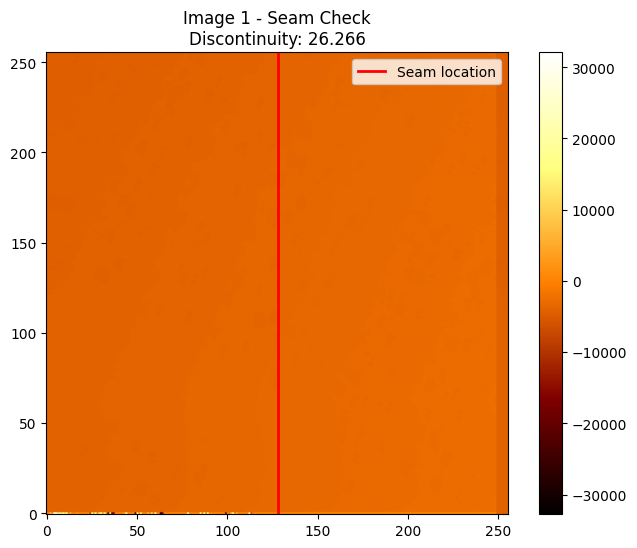

Image 2:
  Seam discontinuity: 329.625
  Overall variation: 1968.424
  Ratio: 0.167
  ✅ Probably fine


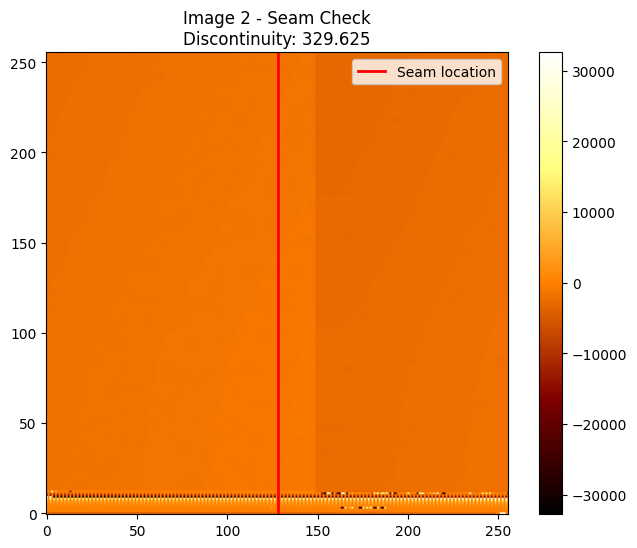

Image 3:
  Seam discontinuity: 325.000
  Overall variation: 1963.750
  Ratio: 0.165
  ✅ Probably fine


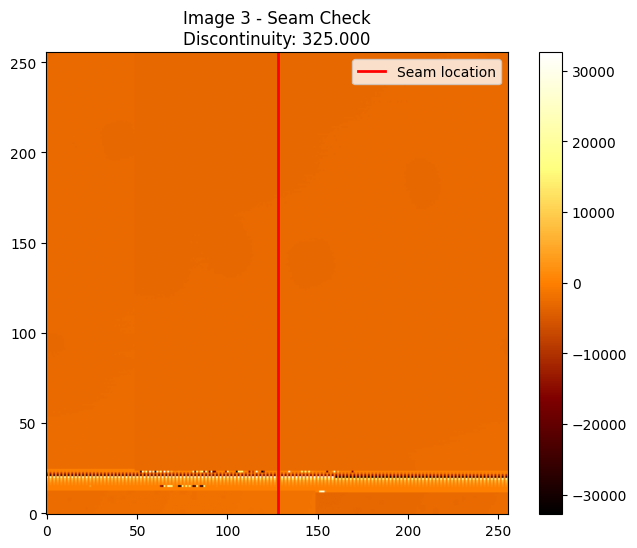

Image 4:
  Seam discontinuity: 322.613
  Overall variation: 1975.977
  Ratio: 0.163
  ✅ Probably fine


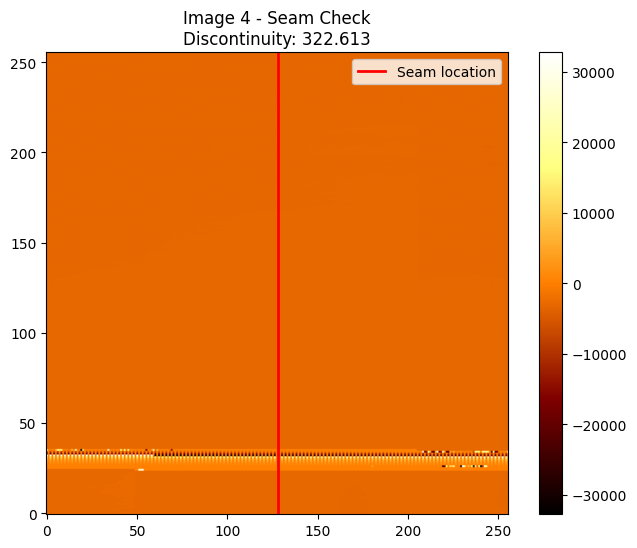

In [2]:
def check_for_seam_issue(filename, dim=256, dtype=np.int16, num_images=4):
    """Just check if images have seam issues without fixing"""
    
    with open(filename, 'rb') as f:
        data = f.read()
    
    image_data = data[7:]
    
    bytes_per_pixel = np.dtype(dtype).itemsize
    bytes_per_image = dim * dim * bytes_per_pixel
    total_bytes = bytes_per_image * num_images
    
    array = np.frombuffer(image_data[:total_bytes], dtype=dtype)
    all_images = array.reshape((num_images, dim, dim))
    
    print("🔍 Checking for seam issues...")
    
    for i, img in enumerate(all_images):
        middle = dim // 2
        
        # Check continuity at middle
        continuity = np.mean(np.abs(img[:, middle-1] - img[:, middle]))
        overall_variation = np.std(img)
        
        print(f"Image {i+1}:")
        print(f"  Seam discontinuity: {continuity:.3f}")
        print(f"  Overall variation: {overall_variation:.3f}")
        print(f"  Ratio: {continuity/overall_variation:.3f}")
        
        if continuity > overall_variation * 0.3:
            print("  ⚠️  Likely has seam issue!")
        else:
            print("  ✅ Probably fine")
        
        # Show the image with seam highlighted
        plt.figure(figsize=(8, 6))
        plt.imshow(img, cmap='afmhot', origin='lower')
        plt.axvline(x=middle, color='red', linewidth=2, label='Seam location')
        plt.colorbar()
        plt.title(f'Image {i+1} - Seam Check\nDiscontinuity: {continuity:.3f}')
        plt.legend()
        plt.show()

# Just check without fixing
check_for_seam_issue('NoName2.mdt')